In [1]:
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tifffile import imread
from skimage import measure, morphology

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
def normalize(img):
    img_cop  = img.copy()
    img_cop  = img_cop.astype('float64') 
    img_min  = np.min(img_cop)
    img_max  = np.max(img_cop)
    img_cop  = (img_cop - img_min)/(img_max - img_min)
    return img_cop

def convert_8bits(img):
    img_copy  = normalize(img)
    img_copy  = np.round(255*img_copy).astype('uint8')
    return img_copy

In [3]:
model = tf.keras.models.load_model('model_segmentation.keras')
img   = imread('data/multi_recorte_1.tif')

In [4]:
# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = 100

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

N      = indx_x.size*indx_y.size

# Cut images
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        block = img[i_idx[:, None], j_idx[None, :], :]
        block = convert_8bits(block)
        X_test[cntr] = block
        cntr  += 1

# Predict images
with tf.device('/cpu:0'):
    Y_test_pred, Y_test_2_pred = model.predict(X_test, verbose=0)

In [5]:
cntr = 0
bufr_1 = np.zeros((Nx, Ny, Nz))
bufr_2 = np.zeros((Nx, Ny, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        predi  = Y_test_2_pred[cntr]
        bufr_1[i_idx[:, None], j_idx[None, :], :] = bufr_1[i_idx[:, None], j_idx[None, :], :] + predi;
        bufr_2[i_idx[:, None], j_idx[None, :], :] = bufr_2[i_idx[:, None], j_idx[None, :], :] + 1;
        cntr  += 1



edge_preditions = normalize(bufr_1/bufr_2)[:,:,0]

In [6]:
# Convert to 8 bits image
edge_preditions_thresh = convert_8bits(edge_preditions>0.25)

# Close open circle countours
edge_preditions_thresh = morphology.closing(edge_preditions_thresh, morphology.square(5))

# Find countours
contours = measure.find_contours(edge_preditions_thresh, level=0.2)

# Count closed contours
closed_contours = [contour for contour in contours if np.allclose(contour[0], contour[-1])]

# Print the number of closed contours
print(f'Number of closed contours: {len(closed_contours)/2}')

Number of closed contours: 406.0


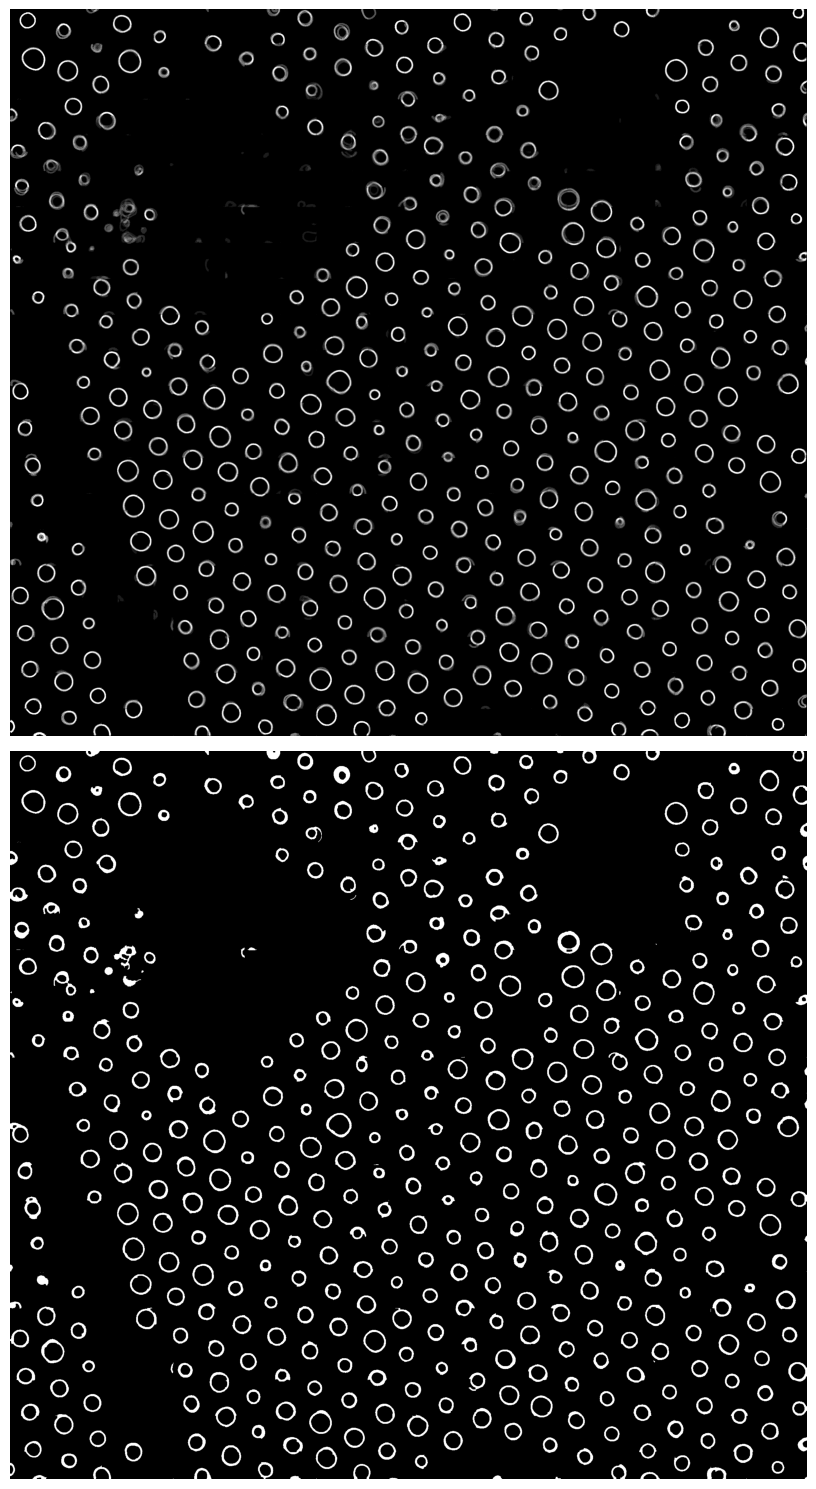

In [7]:
fig, axs = plt.subplots(2,1, figsize = (10,15))
axs[0].imshow(edge_preditions, cmap = 'gray')
axs[0].axis('off')
axs[1].imshow(edge_preditions_thresh, cmap = 'gray')
axs[1].axis('off')
fig.tight_layout()
plt.show()